# Weather Type

The purpose of this notebook is to plot the circulation patterns associated with the various weather types and the time series of weather types

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import calendar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature
import paraguayfloodspy.visualize as viz # custom plotting library
from paraguayfloodspy.pars import GetPars
import matplotlib.patches as patches
%matplotlib inline

Define the extents to use for these plots

Get some consistent color schemes

In [2]:
cmap_streamfunc_a = 'PuOr'
cmap_rain = 'Greens'
cmap_raina = 'BrBG'
my_extent = [275, 330, 5, -45]
rpy_rgn = GetPars('rpy_rain')

Read in raw data

In [3]:
prcpa = xr.open_dataarray("../_data/rainfall/subset/cpc_anom.nc").sel(time = slice('1979-11-01', '2016-02-29'))
psi_850a = xr.open_dataarray("../_data/reanalysis/subset/streamfunc_850_anom.nc").sel(time = slice('1979-11-01', '2016-02-29'))
prcp = xr.open_dataarray("../_data/rainfall/subset/cpc_raw.nc").sel(time = slice('1979-11-01', '2016-02-29'))
psi_850 = xr.open_dataarray("../_data/reanalysis/subset/streamfunc_850_raw.nc").sel(time = slice('1979-11-01', '2016-02-29'))

In [4]:
wtypes = pd.read_csv("../_data/derived/WeatherTypes.csv", index_col='time', parse_dates=True)

Get the X and Y coordinates for plotting

In [5]:
X, Y = np.meshgrid(psi_850.lon, psi_850.lat)
Xp, Yp = np.meshgrid(prcp.lon, prcp.lat)
savefigs = True

Define some contours for the true streamfunctions

In [6]:
lev200 = np.linspace(-1.2e8, 1.2e8, 13)
lev850 = np.linspace(-3.5e7, 3.5e7, 15)

Print out the climatological probability of each weather type

In [7]:
wt_counts = wtypes.groupby('wtype').size()
wt_prop = wt_counts / np.sum(wt_counts)
wt_counts2 = wtypes['2015-11-01':'2016-02-29'].groupby('wtype').size()
wt_prop2 = wt_counts2 / np.sum(wt_counts2)

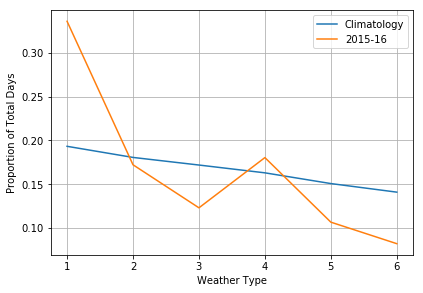

In [8]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(wt_prop, label = "Climatology")
plt.plot(wt_prop2, label = "2015-16")
plt.xlabel("Weather Type")
plt.ylabel("Proportion of Total Days")
plt.legend()
plt.grid()
if savefigs:
    plt.savefig("../_figs/WT_Occurrence_Proportion.pdf")

Repeat for NDJF 2015-16

## Composites

In [9]:
wt_all = np.unique(wtypes['wtype'])
ncols = len(wt_all)

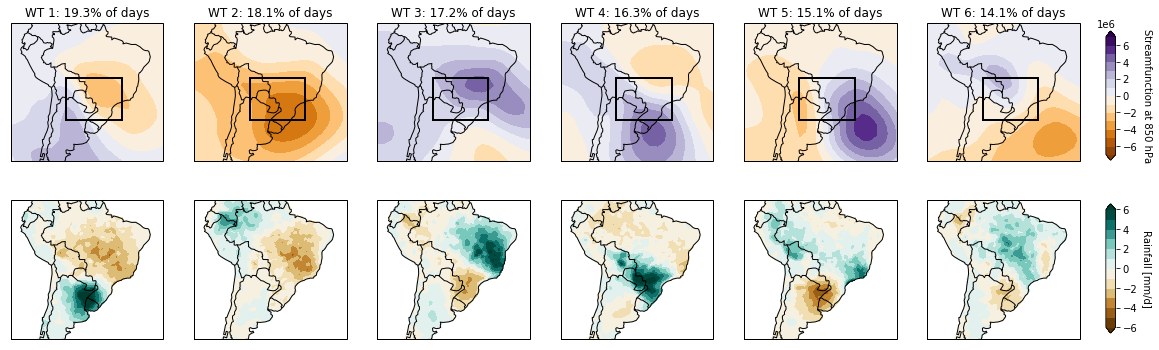

In [10]:
fig, axes = viz.SetupAxes(ncol = ncols, nax = 2 * ncols, proj = ccrs.PlateCarree(), figsize = [18, 6])
fig.subplots_adjust(right=0.95)
cax1 = fig.add_axes([0.97, 0.55, 0.0075, 0.3])
cax2 = fig.add_axes([0.97, 0.15, 0.0075, 0.3])
for i,wt in enumerate(wt_all):
    def selector(ds, wt):
        times = wtypes.loc[wtypes['wtype'] == wt].index
        ds = ds.sel(time = np.in1d(ds.time, times))
        ds = ds.mean(dim = 'time')
        return(ds)

    # Row 1: 850 hPa wind
    ax = axes[0, i]
    ax.set_title('WT {}: {:.1%} of days'.format(wt, wt_prop.values[i]))
    C1 = ax.contourf(X, Y, selector(psi_850a, wt=wt), transform = ccrs.PlateCarree(), 
                     cmap = cmap_streamfunc_a, extend="both", levels=np.linspace(-7e6, 7e6, 15))
    # Indicate WT Region
    ax.add_patch(
            patches.Rectangle((-65, -30), 20,15, #X,Y,dX,dY
                color = 'black', fill = None, linewidth=2, alpha=1))
    
    # Row 2: Rainfall
    ax = axes[1, i]
    sub = selector(prcpa, wt=wt).values
    sub = np.ma.masked_invalid(sub)
    C2 = ax.contourf(Xp, Yp, sub, transform = ccrs.PlateCarree(), 
                     cmap = cmap_raina, levels=np.linspace(-6, 6, 13), extend='both')
# Colorbars for Reanalysis Data
cbar1 = fig.colorbar(C1, cax = cax1)
cbar1.formatter.set_powerlimits((7, 7))
cbar1.update_ticks()
cbar1.set_label(r'Streamfunction at 850 hPa', rotation=270)
cbar1.ax.get_yaxis().labelpad = 15
# Colorbar for Rainfall
cbar2 = fig.colorbar(C2, cax=cax2)
cbar2.set_label(r'Rainfall [mm/d]', rotation=270)
cbar2.ax.get_yaxis().labelpad = 15

viz.FormatAxes(axes, coast=True, grid=False, border=True, river = False,
               feature_list = [], states=False, ticks=None, extent=my_extent)

if savefigs:
    fig.savefig("../_figs/WTComposite.pdf", bbox_inches='tight')

## Time Series

In [11]:
prcp_rpy = prcp.sel(lon = slice(rpy_rgn['lonmin'], rpy_rgn['lonmax']), 
                    lat = slice(rpy_rgn['latmin'], rpy_rgn['latmax'])).mean(dim=['lon', 'lat'])
prcp_rpy_sub = prcp_rpy.sel(time = slice('2015-11-01', '2016-02-29')).to_pandas()
prcp_rpy_sub = pd.DataFrame({'prcp': prcp_rpy_sub})
prcp_rpy = prcp_rpy.to_pandas()
prcp_rpy = prcp_rpy.dropna()

In [12]:
wtypes_sub = wtypes['2015-11-01':'2016-02-29']
wt_prcp = prcp_rpy_sub.join(wtypes_sub)
wt_prcp.head()

,prcp,wtype
time,,
2015-11-01,0.003657,3
2015-11-02,0.713011,6
2015-11-03,2.819442,4
2015-11-04,16.780805,4
2015-11-05,6.319572,5


In [13]:
plt.style.use('ggplot')

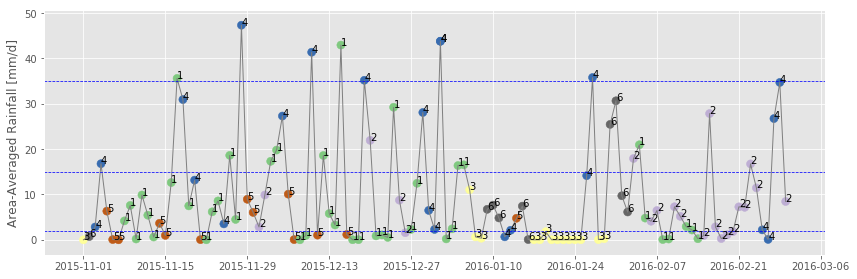

In [14]:
cmap = plt.get_cmap('Accent', 6)
plt.figure(figsize=(14,4.5))
plt.plot(wt_prcp.index, wt_prcp['prcp'], color='gray', linewidth=1)
plt.axhline(np.percentile(prcp_rpy, 50), label="p50", color='blue', linestyle='--', linewidth=0.75)
plt.axhline(np.percentile(prcp_rpy, 90), label="p90", color='blue', linestyle='--', linewidth=0.75)
plt.axhline(np.percentile(prcp_rpy, 99), label="p99", color='blue', linestyle='--', linewidth=0.75)
plt.scatter(wt_prcp.index, wt_prcp['prcp'], c=wt_prcp['wtype'], cmap=cmap, s=65)
plt.ylabel('Area-Averaged Rainfall [mm/d]')
for i,t in enumerate(wt_prcp.index):
    plt.text(t, wt_prcp.iloc[i]['prcp'], '{:d}'.format(np.int(wt_prcp.iloc[i]['wtype'])))
if savefigs:
    plt.savefig("../_figs/RainfallWeatherType.pdf", bbox_inches='tight')